# Machine Learning Project - Predicting NBA Shots

## Project Overview
This project uses the NBA shot data available on Kaggle (<a href="https://www.kaggle.com/datasets/mexwell/nba-shots">https://www.kaggle.com/datasets/mexwell/nba-shots</a>) to classify shots into made vs. miss. I will be using a variety of different models and comparing performance based on metrics such as accuracy and precision in order to determine which model has the best performance.

### Data Overview
The data was downloaded from the Kaggle link above. The link contains 20 years worth of data, however I will only be using data from the 2003-2004 and 2023-2024 seasons. Including more data from other seasons would probably lead to a more robust model, however even one season has around 190 thousand samples which should be more than sufficient for this project. I wanted to include 2 seasons that were relatively far apart to look at longer term trends that might affect the model. For example, as a casual NBA fan, I know that there are more 3-point attempts now as compared to 2003-2004, so I would expect overall make % to be lower. Scoring in general has also increased since 2003-2004, although a portion of that is due to increased free throws which the dataset does not include. I also expect the player to be a significant factor when classifying shots, and there is one player (LeBron James) who is in both the 2003-2004 and 2023-2024 data, so it will be interesting to see how that affects the models as well. I will run each model 3 times, one time for the 2003-2004 data, one time for the 2023-2024 data, and then one time on a combined dataset.



In [74]:
import scipy as sp
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
# Set color map to have light blue background
sns.set()
import statsmodels.formula.api as smf
import statsmodels.api as sm
%matplotlib inline

# To avoid having panda display functions from truncating the columns
pd.set_option('display.max_columns', None)

### Data Size
First I'll load the 2 datasets and look at number of samples and columns

In [83]:
df2004 = pd.read_csv('NBA_2004_Shots.csv')
df2024 = pd.read_csv('NBA_2024_Shots.csv')

df2004.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189803 entries, 0 to 189802
Data columns (total 26 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SEASON_1        189803 non-null  int64  
 1   SEASON_2        189803 non-null  object 
 2   TEAM_ID         189803 non-null  int64  
 3   TEAM_NAME       189803 non-null  object 
 4   PLAYER_ID       189803 non-null  int64  
 5   PLAYER_NAME     189803 non-null  object 
 6   POSITION_GROUP  189803 non-null  object 
 7   POSITION        189803 non-null  object 
 8   GAME_DATE       189803 non-null  object 
 9   GAME_ID         189803 non-null  int64  
 10  HOME_TEAM       189803 non-null  object 
 11  AWAY_TEAM       189803 non-null  object 
 12  EVENT_TYPE      189803 non-null  object 
 13  SHOT_MADE       189803 non-null  bool   
 14  ACTION_TYPE     189803 non-null  object 
 15  SHOT_TYPE       189803 non-null  object 
 16  BASIC_ZONE      189803 non-null  object 
 17  ZONE_NAME 

In [84]:
df2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218701 entries, 0 to 218700
Data columns (total 26 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SEASON_1        218701 non-null  int64  
 1   SEASON_2        218701 non-null  object 
 2   TEAM_ID         218701 non-null  int64  
 3   TEAM_NAME       218701 non-null  object 
 4   PLAYER_ID       218701 non-null  int64  
 5   PLAYER_NAME     218701 non-null  object 
 6   POSITION_GROUP  217437 non-null  object 
 7   POSITION        217437 non-null  object 
 8   GAME_DATE       218701 non-null  object 
 9   GAME_ID         218701 non-null  int64  
 10  HOME_TEAM       218701 non-null  object 
 11  AWAY_TEAM       218701 non-null  object 
 12  EVENT_TYPE      218701 non-null  object 
 13  SHOT_MADE       218701 non-null  bool   
 14  ACTION_TYPE     218701 non-null  object 
 15  SHOT_TYPE       218701 non-null  object 
 16  BASIC_ZONE      218701 non-null  object 
 17  ZONE_NAME 

In [85]:
df2004.head()

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,HOME_TEAM,AWAY_TEAM,EVENT_TYPE,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
0,2004,2003-04,1610612747,Los Angeles Lakers,977,Kobe Bryant,G,SG,04-14-2004,20301187,POR,LAL,Made Shot,True,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center,LC,24+ ft.,20.0,21.35,25,6,0,0
1,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,POR,LAL,Made Shot,True,Driving Layup Shot,2PT Field Goal,Restricted Area,Center,C,Less Than 8 ft.,-0.0,5.25,0,6,0,2
2,2004,2003-04,1610612747,Los Angeles Lakers,977,Kobe Bryant,G,SG,04-14-2004,20301187,POR,LAL,Missed Shot,False,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center,LC,16-24 ft.,13.3,24.45,23,6,0,9
3,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,POR,LAL,Made Shot,True,Jump Shot,2PT Field Goal,Mid-Range,Left Side,L,16-24 ft.,16.4,13.95,18,6,0,31
4,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,POR,LAL,Missed Shot,False,Jump Shot,2PT Field Goal,Mid-Range,Right Side,R,16-24 ft.,-15.8,7.85,16,6,0,55


In [86]:
df2004.describe()

,SEASON_1,TEAM_ID,PLAYER_ID,GAME_ID,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
count,189803.0,1.898030e+05,189803.000000,1.898030e+05,189803.000000,189803.000000,189803.000000,189803.000000,1.898030e+05,189803.000000
mean,2004.0,1.610613e+09,1530.123844,2.030059e+07,0.274000,11.984399,11.595955,2.475388,2.833903e+03,28.669547
std,0.0,8.365408e+00,757.888105,3.434095e+02,11.110596,8.261104,9.546158,1.138648,6.161478e+05,17.466134
min,2004.0,1.610613e+09,15.000000,2.030000e+07,-25.000000,0.050000,0.000000,1.000000,0.000000e+00,0.000000
25%,2004.0,1.610613e+09,947.000000,2.030030e+07,-6.100000,5.250000,0.000000,1.000000,2.000000e+00,14.000000
50%,2004.0,1.610613e+09,1730.000000,2.030059e+07,0.000000,8.350000,13.000000,2.000000,5.000000e+00,29.000000
75%,2004.0,1.610613e+09,2200.000000,2.030089e+07,7.100000,18.250000,19.000000,3.000000,8.000000e+00,44.000000
max,2004.0,1.610613e+09,2724.000000,2.030119e+07,24.800000,90.850000,87.000000,7.000000,1.342177e+08,59.000000


The 2004 data contains about 190 thousand samples, while the 2024 data contains about 220 thousand. Both of the datasets have the same features (some of this information is described on the Kaggle site):<br />
SEASON_1 - The ending year of the season (ex. 2004) - Numeric<br />
SEASON_2 - The season year range (ex. 2003 - 2004) - Text, but 2 numerics<br />
TEAM_ID - The NBA API ID for the team - Numeric<br />
TEAM_NAME - The name of the team - Categorical<br />
PLAYER_ID - The NBA API ID for the player - Numeric<br />
PLAYER_NAME - The name of the player - Categorical<br />
POSITION_GROUP - The position group (ex. Point Guard and Shooting Guard grouped together as Guard) - Categorical<br />
POSITION - Player position - Categorical<br />
GAME_DATE - Date of the game - Date<br />
GAME_ID - NBA API ID for the game - Numeric<br />
HOME_TEAM - The team playing at home - Categorical<br />
AWAY_TEAM - The team playing away - Categorical<br />
EVENT_TYPE - Text of whether the shot was a make or a miss - Categorical<br />
SHOT_MADE - Whether the shot was make or a miss as a boolean - This is the classifier for the project - Bool<br />
ACTION_TYPE - General categorization of the shot (layup, slam dunk, jump shot, etc.) - Categorical<br />
SHOT_TYPE - Whether the shot was a 2 or 3 pointer - Categorical<br />
BASIC_ZONE - The court zone where the shot was taken - Categorical<br />
ZONE_NAME - The side of the court where the shot was taken - Categorical<br />
ZONE_ABB - The abbreviation of the zone - Categorical<br />
ZONE_RANGE - Distance range of the shot (ex. < 8 feet, 8 - 16 feet, etc.) - Categorical<br />
LOC_X - The X coordinate of where the shot was taken - Numeric<br />
LOC_Y - The Y coordinate of where the shot was taken - Numeric<br />
SHOT_DISTANCE - The distance from the basket - Numeric<br/>
QUARTER - Which quarter of the game the shot was taken. Overtime games will have quarter values higher than 4 (for OT, double OT, triple OT, etc.) - Numeric<br />
MINS_LEFT - How many minutes are remaining in the quarter - Numeric<br />
SECS_LEFT - How many seconds are remaining in the quarter - Numeric

### Data Cleaning
There are a number of redundant features which would lead to correlation issues if left in the dataset, so those will be removed now. Those features are:<br />
TEAM_ID, PLAYER_ID, GAME_ID - IDs from the NBA API which have no use for this project<br />
SEASON_2 - The SEASON_1 attribute is enough to distinguish the datasets by year<br />
POSITION_GROUP - This is just a generalization of the POSITION feature<br />
GAME_DATE - Would likely lead to overfitting for games where a player had an abnormally high amount of makes / misses<br />
EVENT_TYPE - Just a friendlier text version of SHOT_MADE which is our classifier<br />
BASIC_ZONE, ZONE_NAME, ZONE_ABB, ZONE_RANGE - These are unnecessary with the LOC_X, LOC_Y, and SHOT_DISTANCE features which specify the exact location for the shot. 


In [87]:
df2004 = df2004.drop(['TEAM_ID', 'PLAYER_ID', 'GAME_ID', 'SEASON_2', 'POSITION_GROUP', 'GAME_DATE', 'EVENT_TYPE', 'BASIC_ZONE', 'ZONE_NAME', 'ZONE_ABB', 'ZONE_RANGE'], axis = 1)
df2024 = df2024.drop(['TEAM_ID', 'PLAYER_ID', 'GAME_ID', 'SEASON_2', 'POSITION_GROUP', 'GAME_DATE', 'EVENT_TYPE', 'BASIC_ZONE', 'ZONE_NAME', 'ZONE_ABB', 'ZONE_RANGE'], axis = 1)

df2004.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189803 entries, 0 to 189802
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   SEASON_1       189803 non-null  int64  
 1   TEAM_NAME      189803 non-null  object 
 2   PLAYER_NAME    189803 non-null  object 
 3   POSITION       189803 non-null  object 
 4   HOME_TEAM      189803 non-null  object 
 5   AWAY_TEAM      189803 non-null  object 
 6   SHOT_MADE      189803 non-null  bool   
 7   ACTION_TYPE    189803 non-null  object 
 8   SHOT_TYPE      189803 non-null  object 
 9   LOC_X          189803 non-null  float64
 10  LOC_Y          189803 non-null  float64
 11  SHOT_DISTANCE  189803 non-null  int64  
 12  QUARTER        189803 non-null  int64  
 13  MINS_LEFT      189803 non-null  int64  
 14  SECS_LEFT      189803 non-null  int64  
dtypes: bool(1), float64(2), int64(5), object(7)
memory usage: 20.5+ MB


In [88]:
df2004.head()

,SEASON_1,TEAM_NAME,PLAYER_NAME,POSITION,HOME_TEAM,AWAY_TEAM,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
0,2004,Los Angeles Lakers,Kobe Bryant,SG,POR,LAL,True,Jump Shot,3PT Field Goal,20.0,21.35,25,6,0,0
1,2004,Portland Trail Blazers,Damon Stoudamire,PG,POR,LAL,True,Driving Layup Shot,2PT Field Goal,-0.0,5.25,0,6,0,2
2,2004,Los Angeles Lakers,Kobe Bryant,SG,POR,LAL,False,Jump Shot,2PT Field Goal,13.3,24.45,23,6,0,9
3,2004,Portland Trail Blazers,Damon Stoudamire,PG,POR,LAL,True,Jump Shot,2PT Field Goal,16.4,13.95,18,6,0,31
4,2004,Portland Trail Blazers,Damon Stoudamire,PG,POR,LAL,False,Jump Shot,2PT Field Goal,-15.8,7.85,16,6,0,55


In [89]:
df2004.describe()

,SEASON_1,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
count,189803.0,189803.000000,189803.000000,189803.000000,189803.000000,1.898030e+05,189803.000000
mean,2004.0,0.274000,11.984399,11.595955,2.475388,2.833903e+03,28.669547
std,0.0,11.110596,8.261104,9.546158,1.138648,6.161478e+05,17.466134
min,2004.0,-25.000000,0.050000,0.000000,1.000000,0.000000e+00,0.000000
25%,2004.0,-6.100000,5.250000,0.000000,1.000000,2.000000e+00,14.000000
50%,2004.0,0.000000,8.350000,13.000000,2.000000,5.000000e+00,29.000000
75%,2004.0,7.100000,18.250000,19.000000,3.000000,8.000000e+00,44.000000
max,2004.0,24.800000,90.850000,87.000000,7.000000,1.342177e+08,59.000000


There aren't any NaNs or null values and the data types for the remaining features are all correct. I would like to add a feature to replace the HOME_TEAM and AWAY_TEAM with a single feature indicating if the player that took the shot is playing at home in order to better suggest the relation between a player playing at home having a positive effect on their shot percentage. Unfortunately the HOME_TEAM and AWAY_TEAM use the 3 letter abbreviation while the TEAM_NAME uses the full team name, so this is a bit cumbersome.

In [90]:
# Use .agg() to get the most common HOME_TEAM value for each TEAM_NAME - this will be the translation between TEAM_NAME and HOME_TEAM
translation2004 = df2004.groupby('TEAM_NAME')['HOME_TEAM'].agg(pd.Series.mode).to_dict()
translation2024 = df2024.groupby('TEAM_NAME')['HOME_TEAM'].agg(pd.Series.mode).to_dict()
#print(translation2004)
#print(translation2024)

# create the IS_HOME feature and populate it using the dictionary
df2004['IS_HOME'] = df2004.apply(lambda x: translation2004[x['TEAM_NAME']] == x['HOME_TEAM'], axis=1)
df2024['IS_HOME'] = df2024.apply(lambda x: translation2024[x['TEAM_NAME']] == x['HOME_TEAM'], axis=1)

# drop unneeded features
df2004 = df2004.drop(['HOME_TEAM', 'AWAY_TEAM'], axis = 1)
df2024 = df2024.drop(['HOME_TEAM', 'AWAY_TEAM'], axis = 1)

#df2004.info()
df2004.head()

,SEASON_1,TEAM_NAME,PLAYER_NAME,POSITION,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,IS_HOME
0,2004,Los Angeles Lakers,Kobe Bryant,SG,True,Jump Shot,3PT Field Goal,20.0,21.35,25,6,0,0,False
1,2004,Portland Trail Blazers,Damon Stoudamire,PG,True,Driving Layup Shot,2PT Field Goal,-0.0,5.25,0,6,0,2,True
2,2004,Los Angeles Lakers,Kobe Bryant,SG,False,Jump Shot,2PT Field Goal,13.3,24.45,23,6,0,9,False
3,2004,Portland Trail Blazers,Damon Stoudamire,PG,True,Jump Shot,2PT Field Goal,16.4,13.95,18,6,0,31,True
4,2004,Portland Trail Blazers,Damon Stoudamire,PG,False,Jump Shot,2PT Field Goal,-15.8,7.85,16,6,0,55,True


I want to change SHOT_TYPE from a categorical variable to a numeric one, as the only values are '3PT Field Goal' and '2PT Field Goal'. This new variable will be IS_THREE indicating if the shot was a 3-pointer.

In [101]:
print(df2004['SHOT_TYPE'].unique())

df2004['IS_THREE'] = df2004.apply(lambda x: x['SHOT_TYPE'][0] == '3', axis=1)
df2024['IS_THREE'] = df2024.apply(lambda x: x['SHOT_TYPE'][0] == '3', axis=1)

df2004 = df2004.drop('SHOT_TYPE', axis = 1)
df2024 = df2024.drop('SHOT_TYPE', axis = 1)

df2004.head()

['3PT Field Goal' '2PT Field Goal']


,SEASON_1,TEAM_NAME,PLAYER_NAME,POSITION,SHOT_MADE,ACTION_TYPE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,IS_HOME,IS_THREE
0,2004,Los Angeles Lakers,Kobe Bryant,SG,True,Jump Shot,20.0,21.35,25,6,0,0,False,True
1,2004,Portland Trail Blazers,Damon Stoudamire,PG,True,Driving Layup Shot,-0.0,5.25,0,6,0,2,True,False
2,2004,Los Angeles Lakers,Kobe Bryant,SG,False,Jump Shot,13.3,24.45,23,6,0,9,False,False
3,2004,Portland Trail Blazers,Damon Stoudamire,PG,True,Jump Shot,16.4,13.95,18,6,0,31,True,False
4,2004,Portland Trail Blazers,Damon Stoudamire,PG,False,Jump Shot,-15.8,7.85,16,6,0,55,True,False


Finally, I will merge the 2 datasets and then drop the SEASON_1 feature on the individual datasets, since it has the same value for all samples (either 2004 or 2024). I'll also rename it to YEAR on the merged dataset to give it a more useful name.

In [108]:
# create a merged dataset
df_merged = pd.concat([df2004, df2024]).rename({'SEASON_1' : 'YEAR'}, axis = 1)

df2004 = df2004.drop('SEASON_1', axis = 1)
df2024 = df2024.drop('SEASON_1', axis = 1)

## Final Datasets

### 2004

In [113]:
df2004.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189803 entries, 0 to 189802
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TEAM_NAME      189803 non-null  object 
 1   PLAYER_NAME    189803 non-null  object 
 2   POSITION       189803 non-null  object 
 3   SHOT_MADE      189803 non-null  bool   
 4   ACTION_TYPE    189803 non-null  object 
 5   LOC_X          189803 non-null  float64
 6   LOC_Y          189803 non-null  float64
 7   SHOT_DISTANCE  189803 non-null  int64  
 8   QUARTER        189803 non-null  int64  
 9   MINS_LEFT      189803 non-null  int64  
 10  SECS_LEFT      189803 non-null  int64  
 11  IS_HOME        189803 non-null  bool   
 12  IS_THREE       189803 non-null  bool   
dtypes: bool(3), float64(2), int64(4), object(4)
memory usage: 15.0+ MB


In [114]:
df2004.head()

,TEAM_NAME,PLAYER_NAME,POSITION,SHOT_MADE,ACTION_TYPE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,IS_HOME,IS_THREE
0,Los Angeles Lakers,Kobe Bryant,SG,True,Jump Shot,20.0,21.35,25,6,0,0,False,True
1,Portland Trail Blazers,Damon Stoudamire,PG,True,Driving Layup Shot,-0.0,5.25,0,6,0,2,True,False
2,Los Angeles Lakers,Kobe Bryant,SG,False,Jump Shot,13.3,24.45,23,6,0,9,False,False
3,Portland Trail Blazers,Damon Stoudamire,PG,True,Jump Shot,16.4,13.95,18,6,0,31,True,False
4,Portland Trail Blazers,Damon Stoudamire,PG,False,Jump Shot,-15.8,7.85,16,6,0,55,True,False


### 2024

In [115]:
df2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218701 entries, 0 to 218700
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TEAM_NAME      218701 non-null  object 
 1   PLAYER_NAME    218701 non-null  object 
 2   POSITION       217437 non-null  object 
 3   SHOT_MADE      218701 non-null  bool   
 4   ACTION_TYPE    218701 non-null  object 
 5   LOC_X          218701 non-null  float64
 6   LOC_Y          218701 non-null  float64
 7   SHOT_DISTANCE  218701 non-null  int64  
 8   QUARTER        218701 non-null  int64  
 9   MINS_LEFT      218701 non-null  int64  
 10  SECS_LEFT      218701 non-null  int64  
 11  IS_HOME        218701 non-null  bool   
 12  IS_THREE       218701 non-null  bool   
dtypes: bool(3), float64(2), int64(4), object(4)
memory usage: 17.3+ MB


In [116]:
df2024.head()

,TEAM_NAME,PLAYER_NAME,POSITION,SHOT_MADE,ACTION_TYPE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,IS_HOME,IS_THREE
0,Washington Wizards,Jordan Poole,SG,False,Driving Floating Jump Shot,-0.4,17.45,12,1,11,1,False,False
1,Washington Wizards,Deni Avdija,SF,True,Jump Shot,1.5,30.55,25,1,10,26,False,True
2,Washington Wizards,Tyus Jones,PG,True,Driving Layup Shot,-3.3,6.55,3,1,9,46,False,False
3,Washington Wizards,Jordan Poole,SG,True,Running Finger Roll Layup Shot,-1.0,5.85,1,1,8,30,False,False
4,Washington Wizards,Tyus Jones,PG,True,Cutting Layup Shot,-0.0,6.25,1,1,8,8,False,False


### Merged

In [117]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 408504 entries, 0 to 218700
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   YEAR           408504 non-null  int64  
 1   TEAM_NAME      408504 non-null  object 
 2   PLAYER_NAME    408504 non-null  object 
 3   POSITION       407240 non-null  object 
 4   SHOT_MADE      408504 non-null  bool   
 5   ACTION_TYPE    408504 non-null  object 
 6   LOC_X          408504 non-null  float64
 7   LOC_Y          408504 non-null  float64
 8   SHOT_DISTANCE  408504 non-null  int64  
 9   QUARTER        408504 non-null  int64  
 10  MINS_LEFT      408504 non-null  int64  
 11  SECS_LEFT      408504 non-null  int64  
 12  IS_HOME        408504 non-null  bool   
 13  IS_THREE       408504 non-null  bool   
dtypes: bool(3), float64(2), int64(5), object(4)
memory usage: 38.6+ MB


In [118]:
df_merged.head()

,YEAR,TEAM_NAME,PLAYER_NAME,POSITION,SHOT_MADE,ACTION_TYPE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,IS_HOME,IS_THREE
0,2004,Los Angeles Lakers,Kobe Bryant,SG,True,Jump Shot,20.0,21.35,25,6,0,0,False,True
1,2004,Portland Trail Blazers,Damon Stoudamire,PG,True,Driving Layup Shot,-0.0,5.25,0,6,0,2,True,False
2,2004,Los Angeles Lakers,Kobe Bryant,SG,False,Jump Shot,13.3,24.45,23,6,0,9,False,False
3,2004,Portland Trail Blazers,Damon Stoudamire,PG,True,Jump Shot,16.4,13.95,18,6,0,31,True,False
4,2004,Portland Trail Blazers,Damon Stoudamire,PG,False,Jump Shot,-15.8,7.85,16,6,0,55,True,False


### EDA
I'll look at the heatmaps and the pairplots for the 3 datasets. I'll need to remove the 4 categorical features for this in order to generate the correlation matrix. The pairplots wouldn't generate due to the large number of samples, so I limited the pairplots to 2000 samples selected at random.

### 2004

<Axes: >

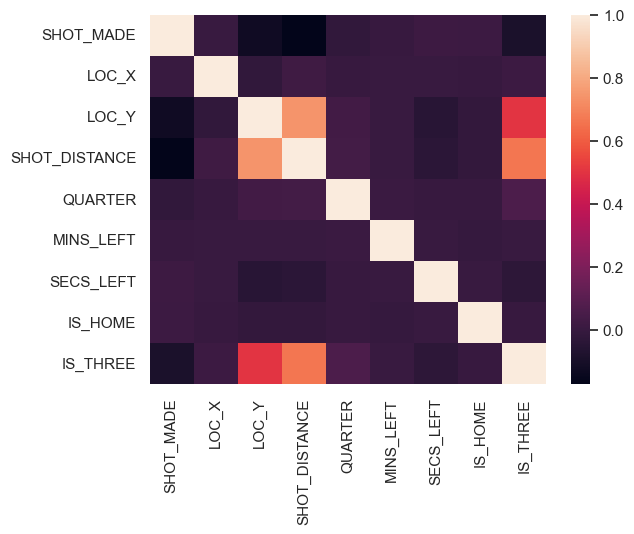

In [126]:
sns.heatmap(df2004.drop(['TEAM_NAME', 'PLAYER_NAME', 'POSITION', 'ACTION_TYPE'], axis = 1).corr())

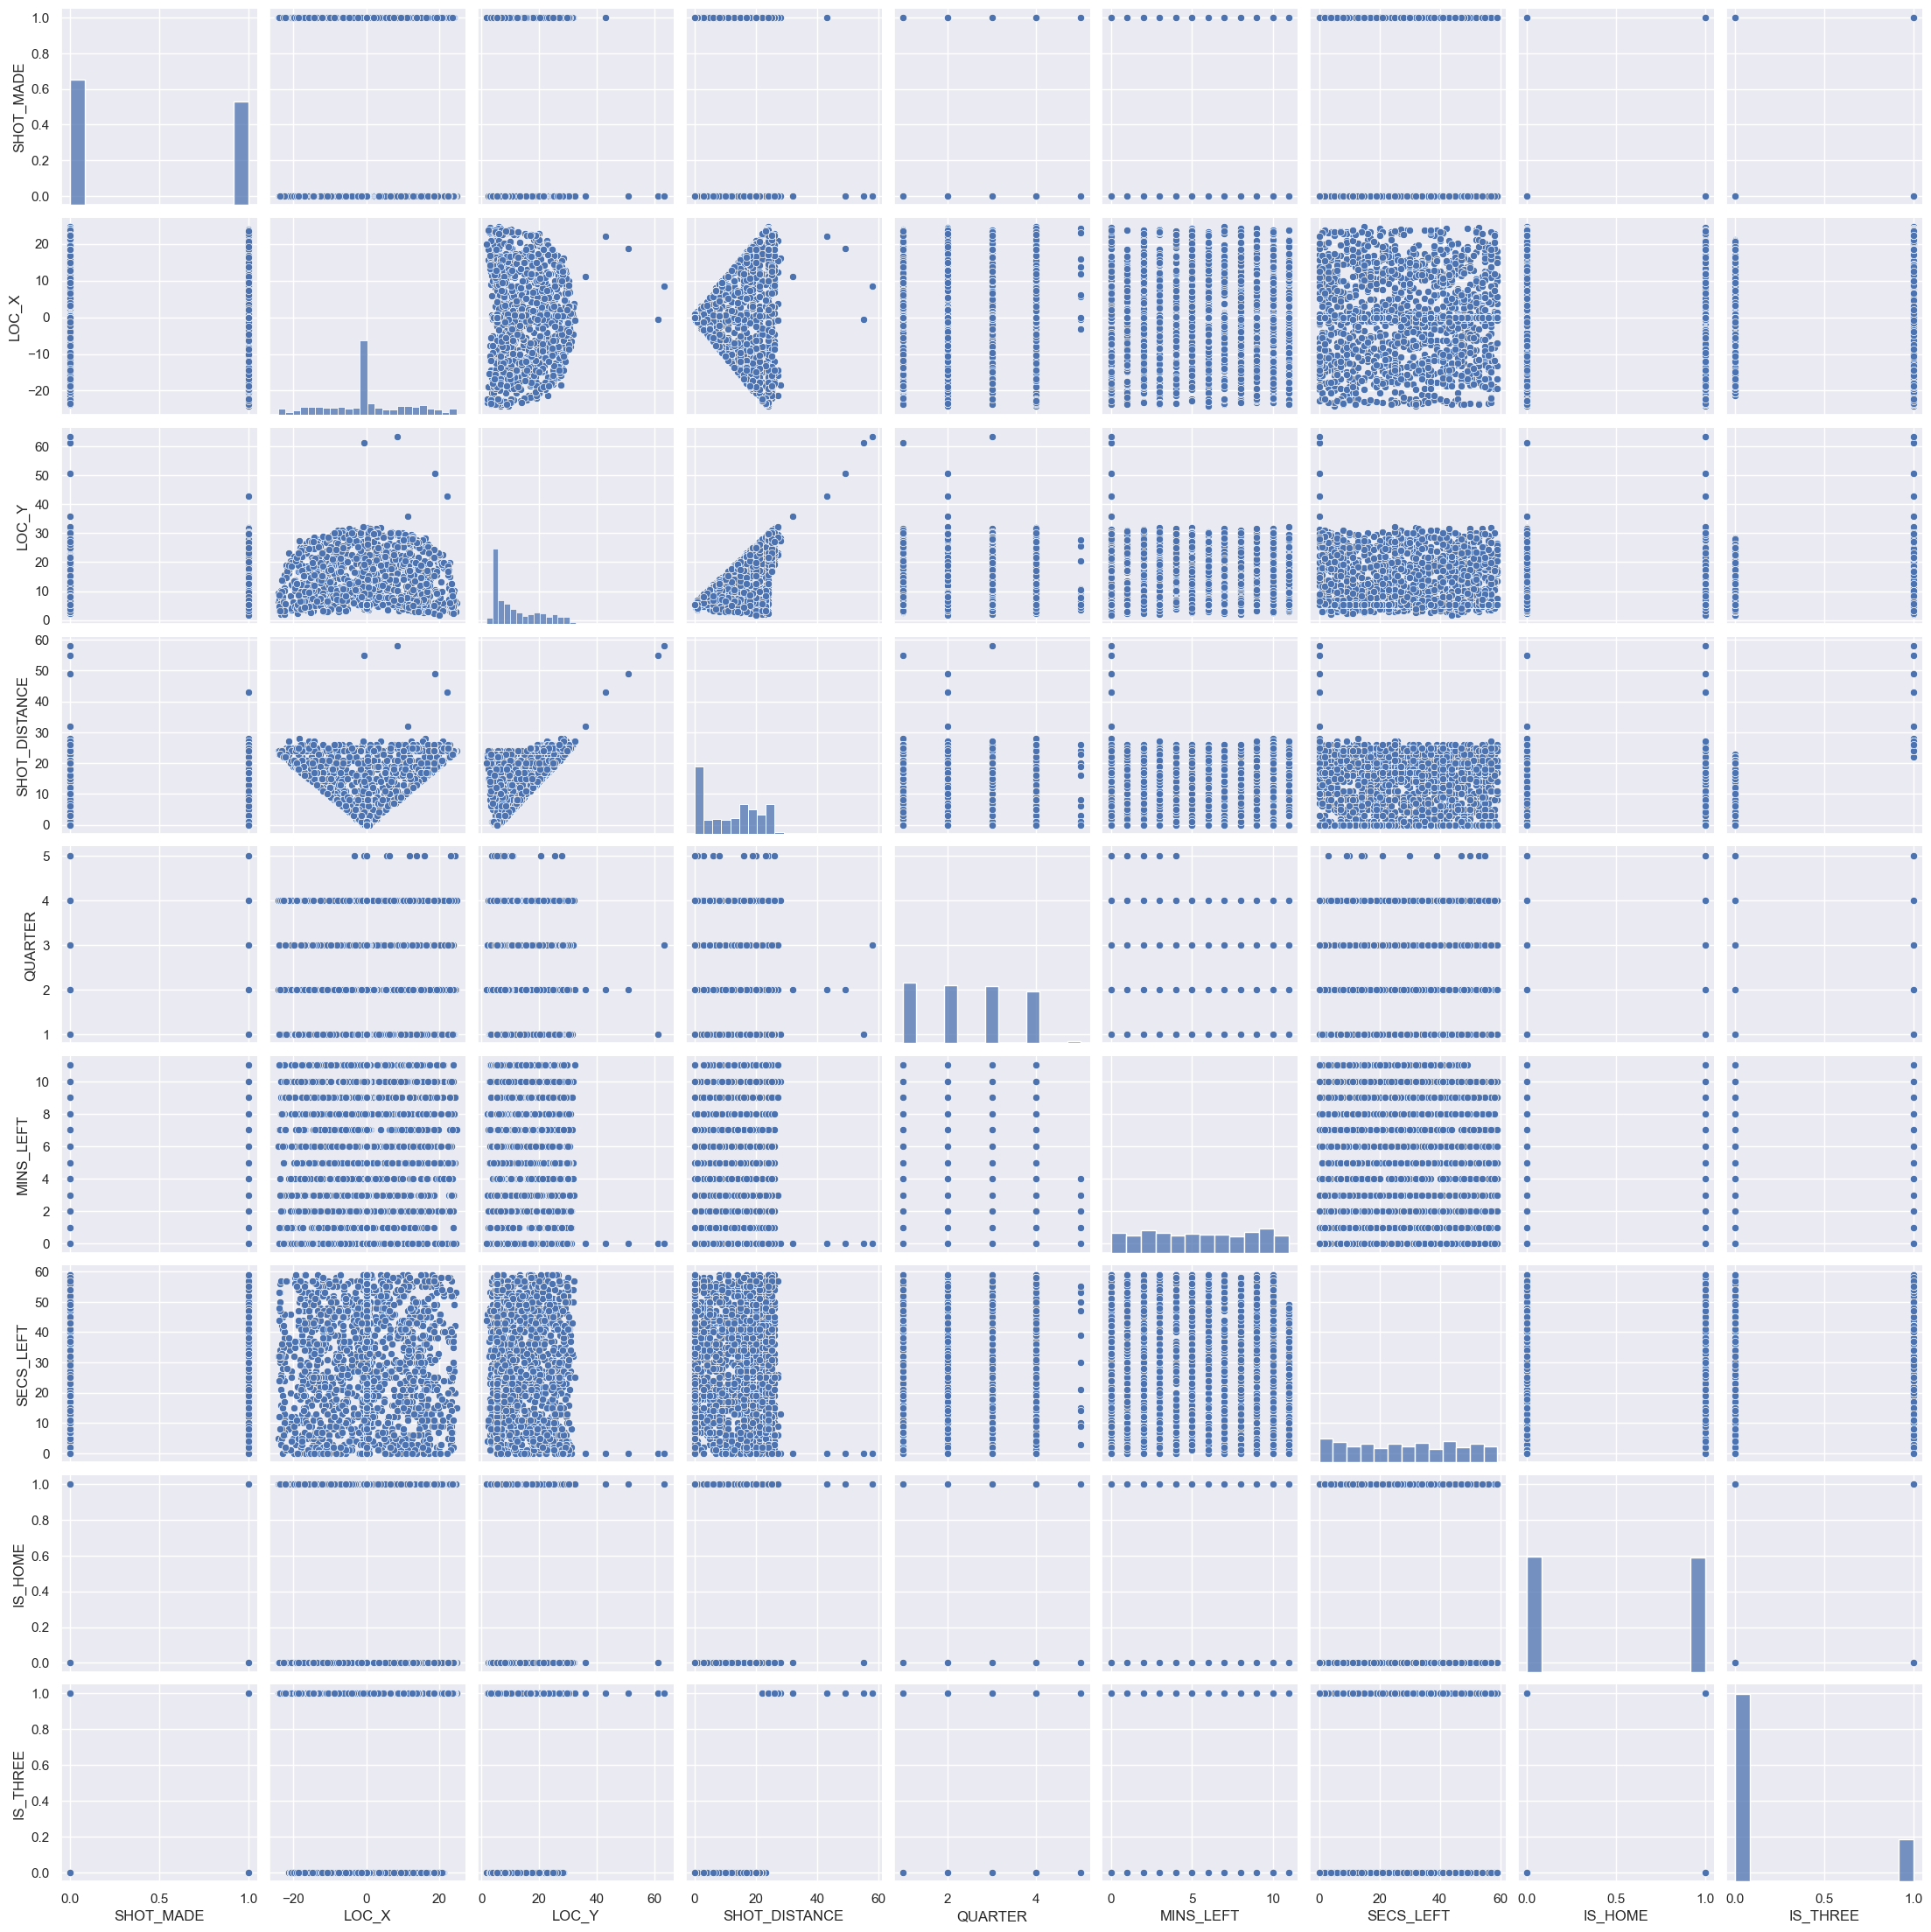

In [132]:
sns.pairplot(df2004.sample(2000))

### 2024

<Axes: >

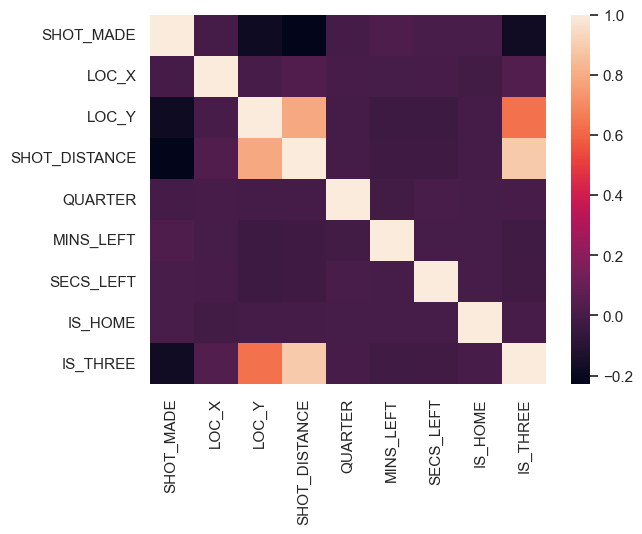

In [130]:
sns.heatmap(df2024.drop(['TEAM_NAME', 'PLAYER_NAME', 'POSITION', 'ACTION_TYPE'], axis = 1).corr())

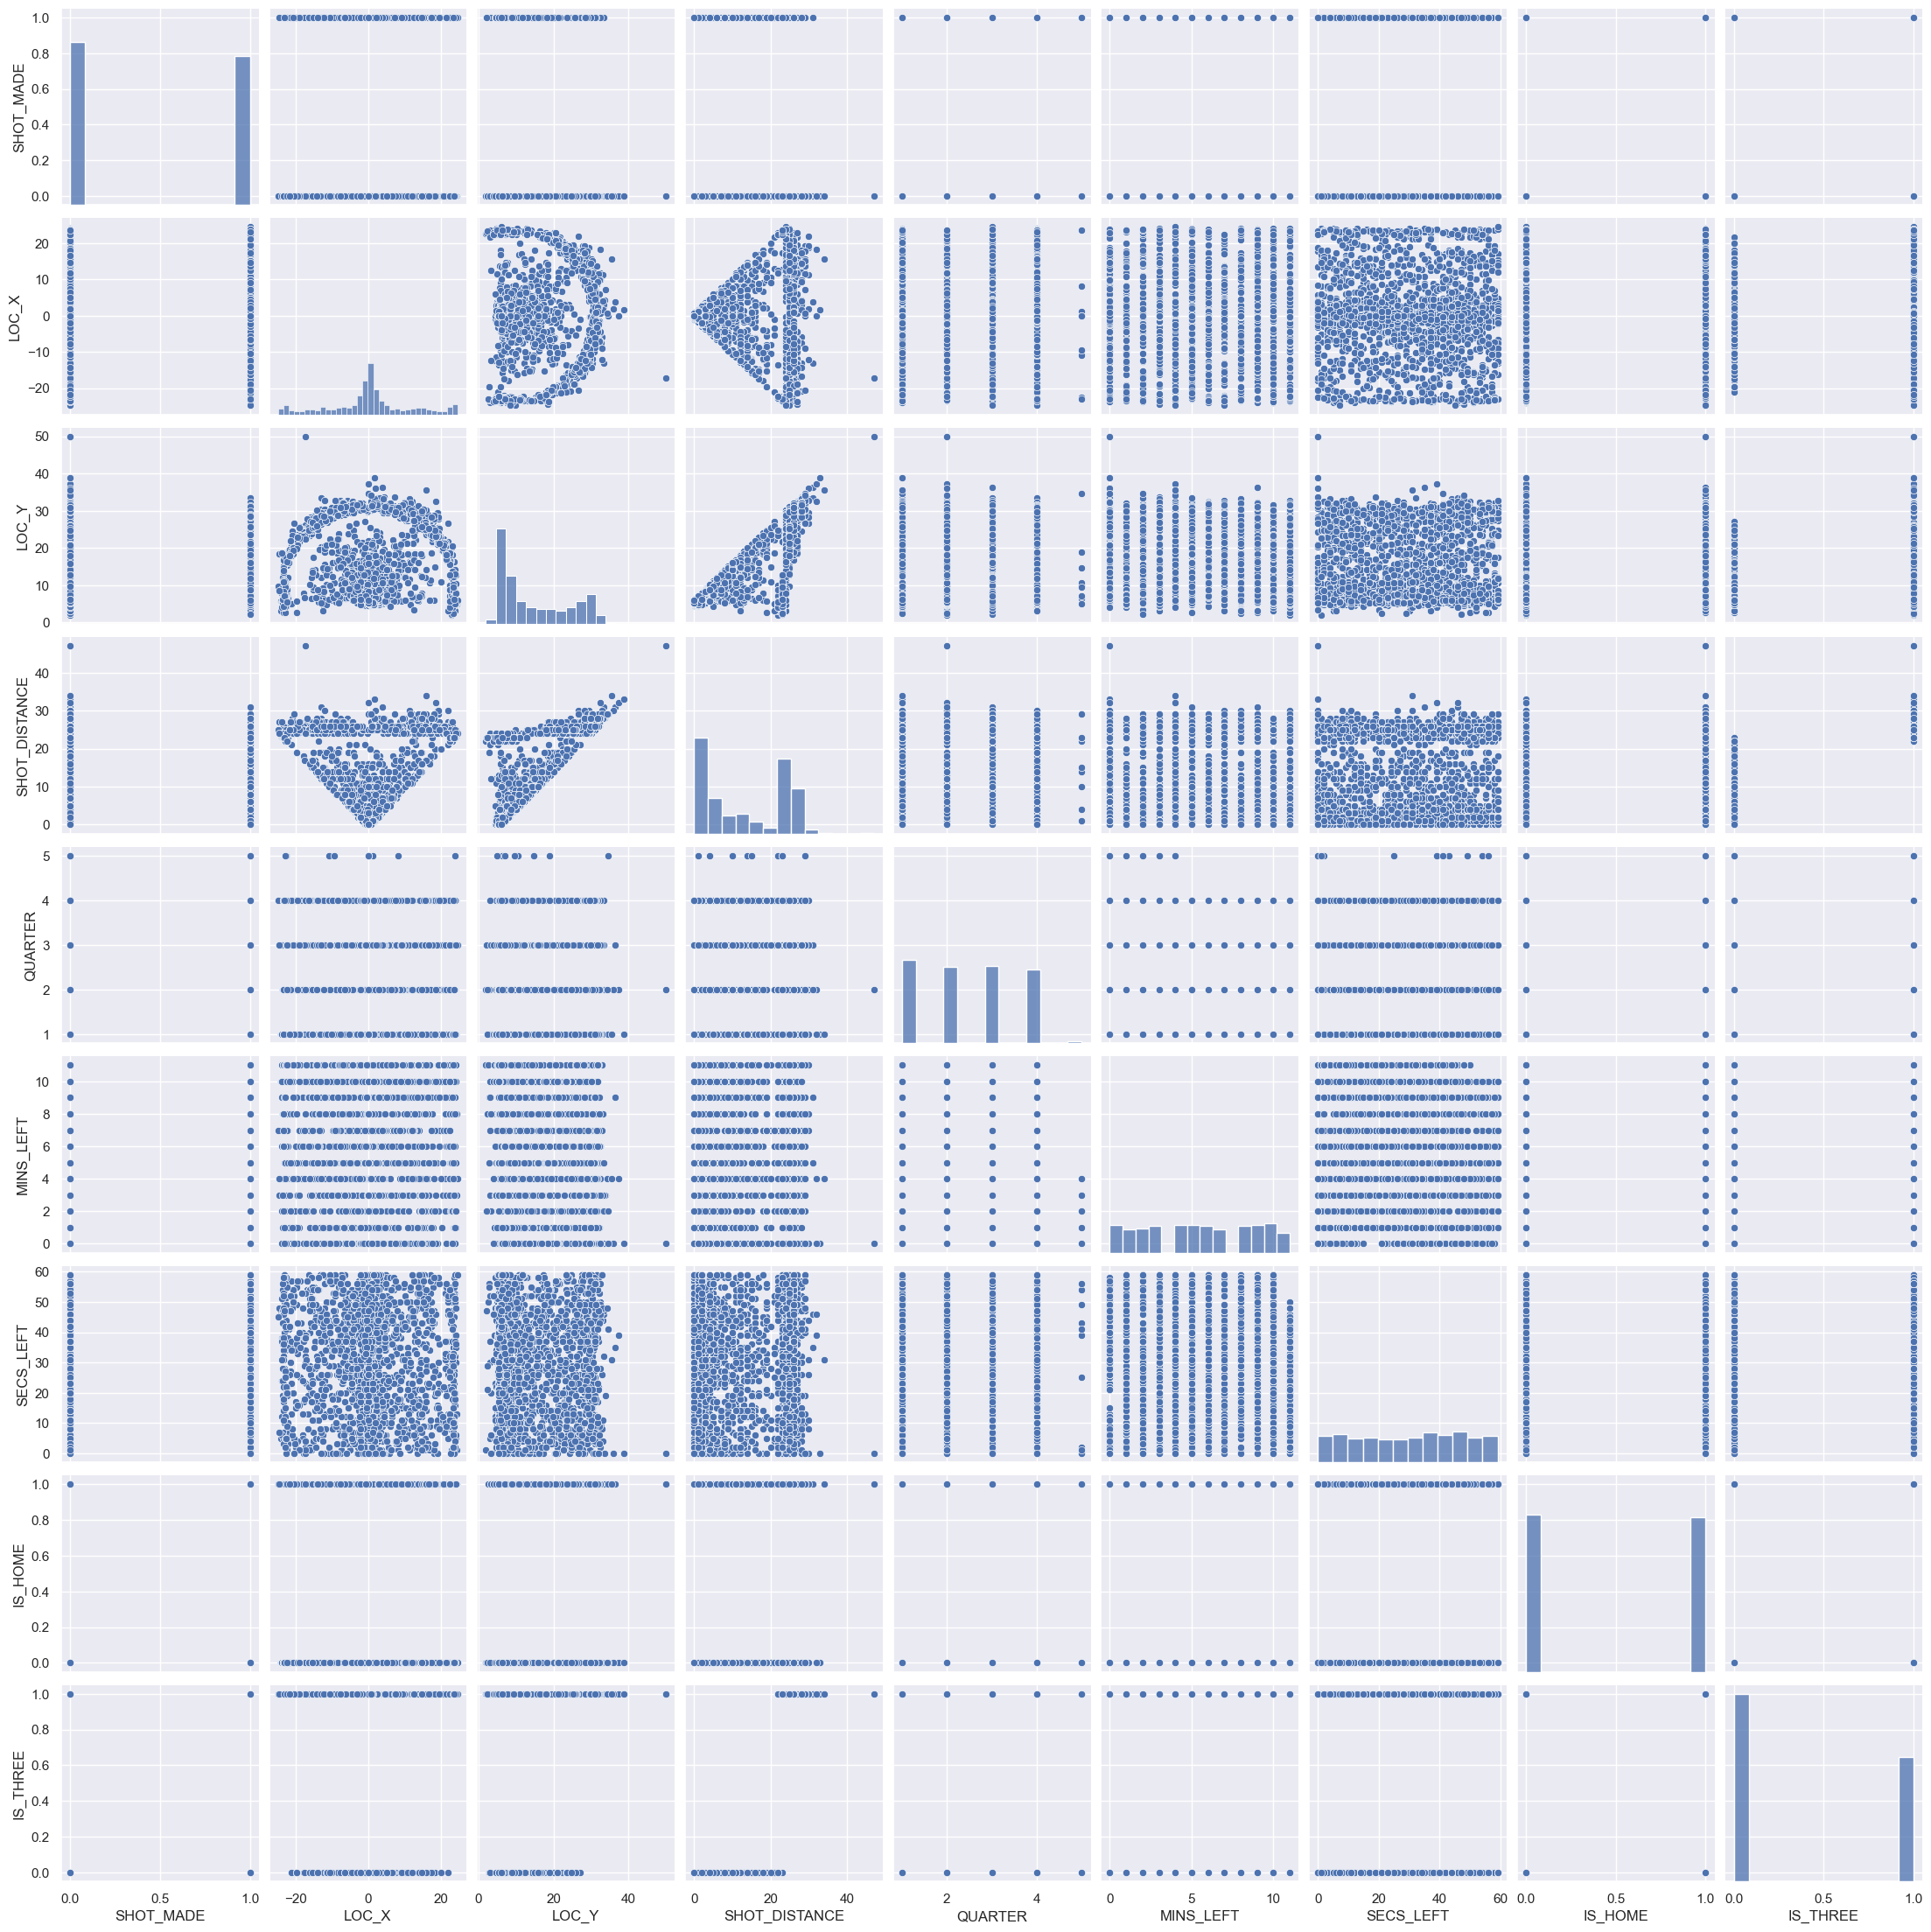

In [133]:
sns.pairplot(df2024.sample(2000))

### Merged

<Axes: >

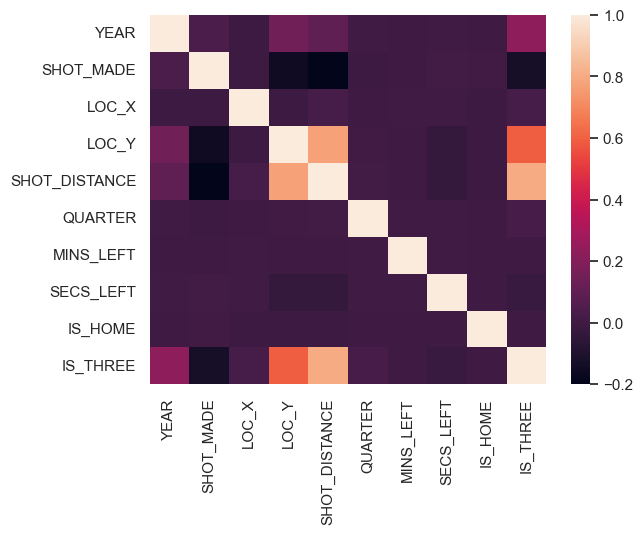

In [124]:
sns.heatmap(df_merged.drop(['TEAM_NAME', 'PLAYER_NAME', 'POSITION', 'ACTION_TYPE'], axis = 1).corr())

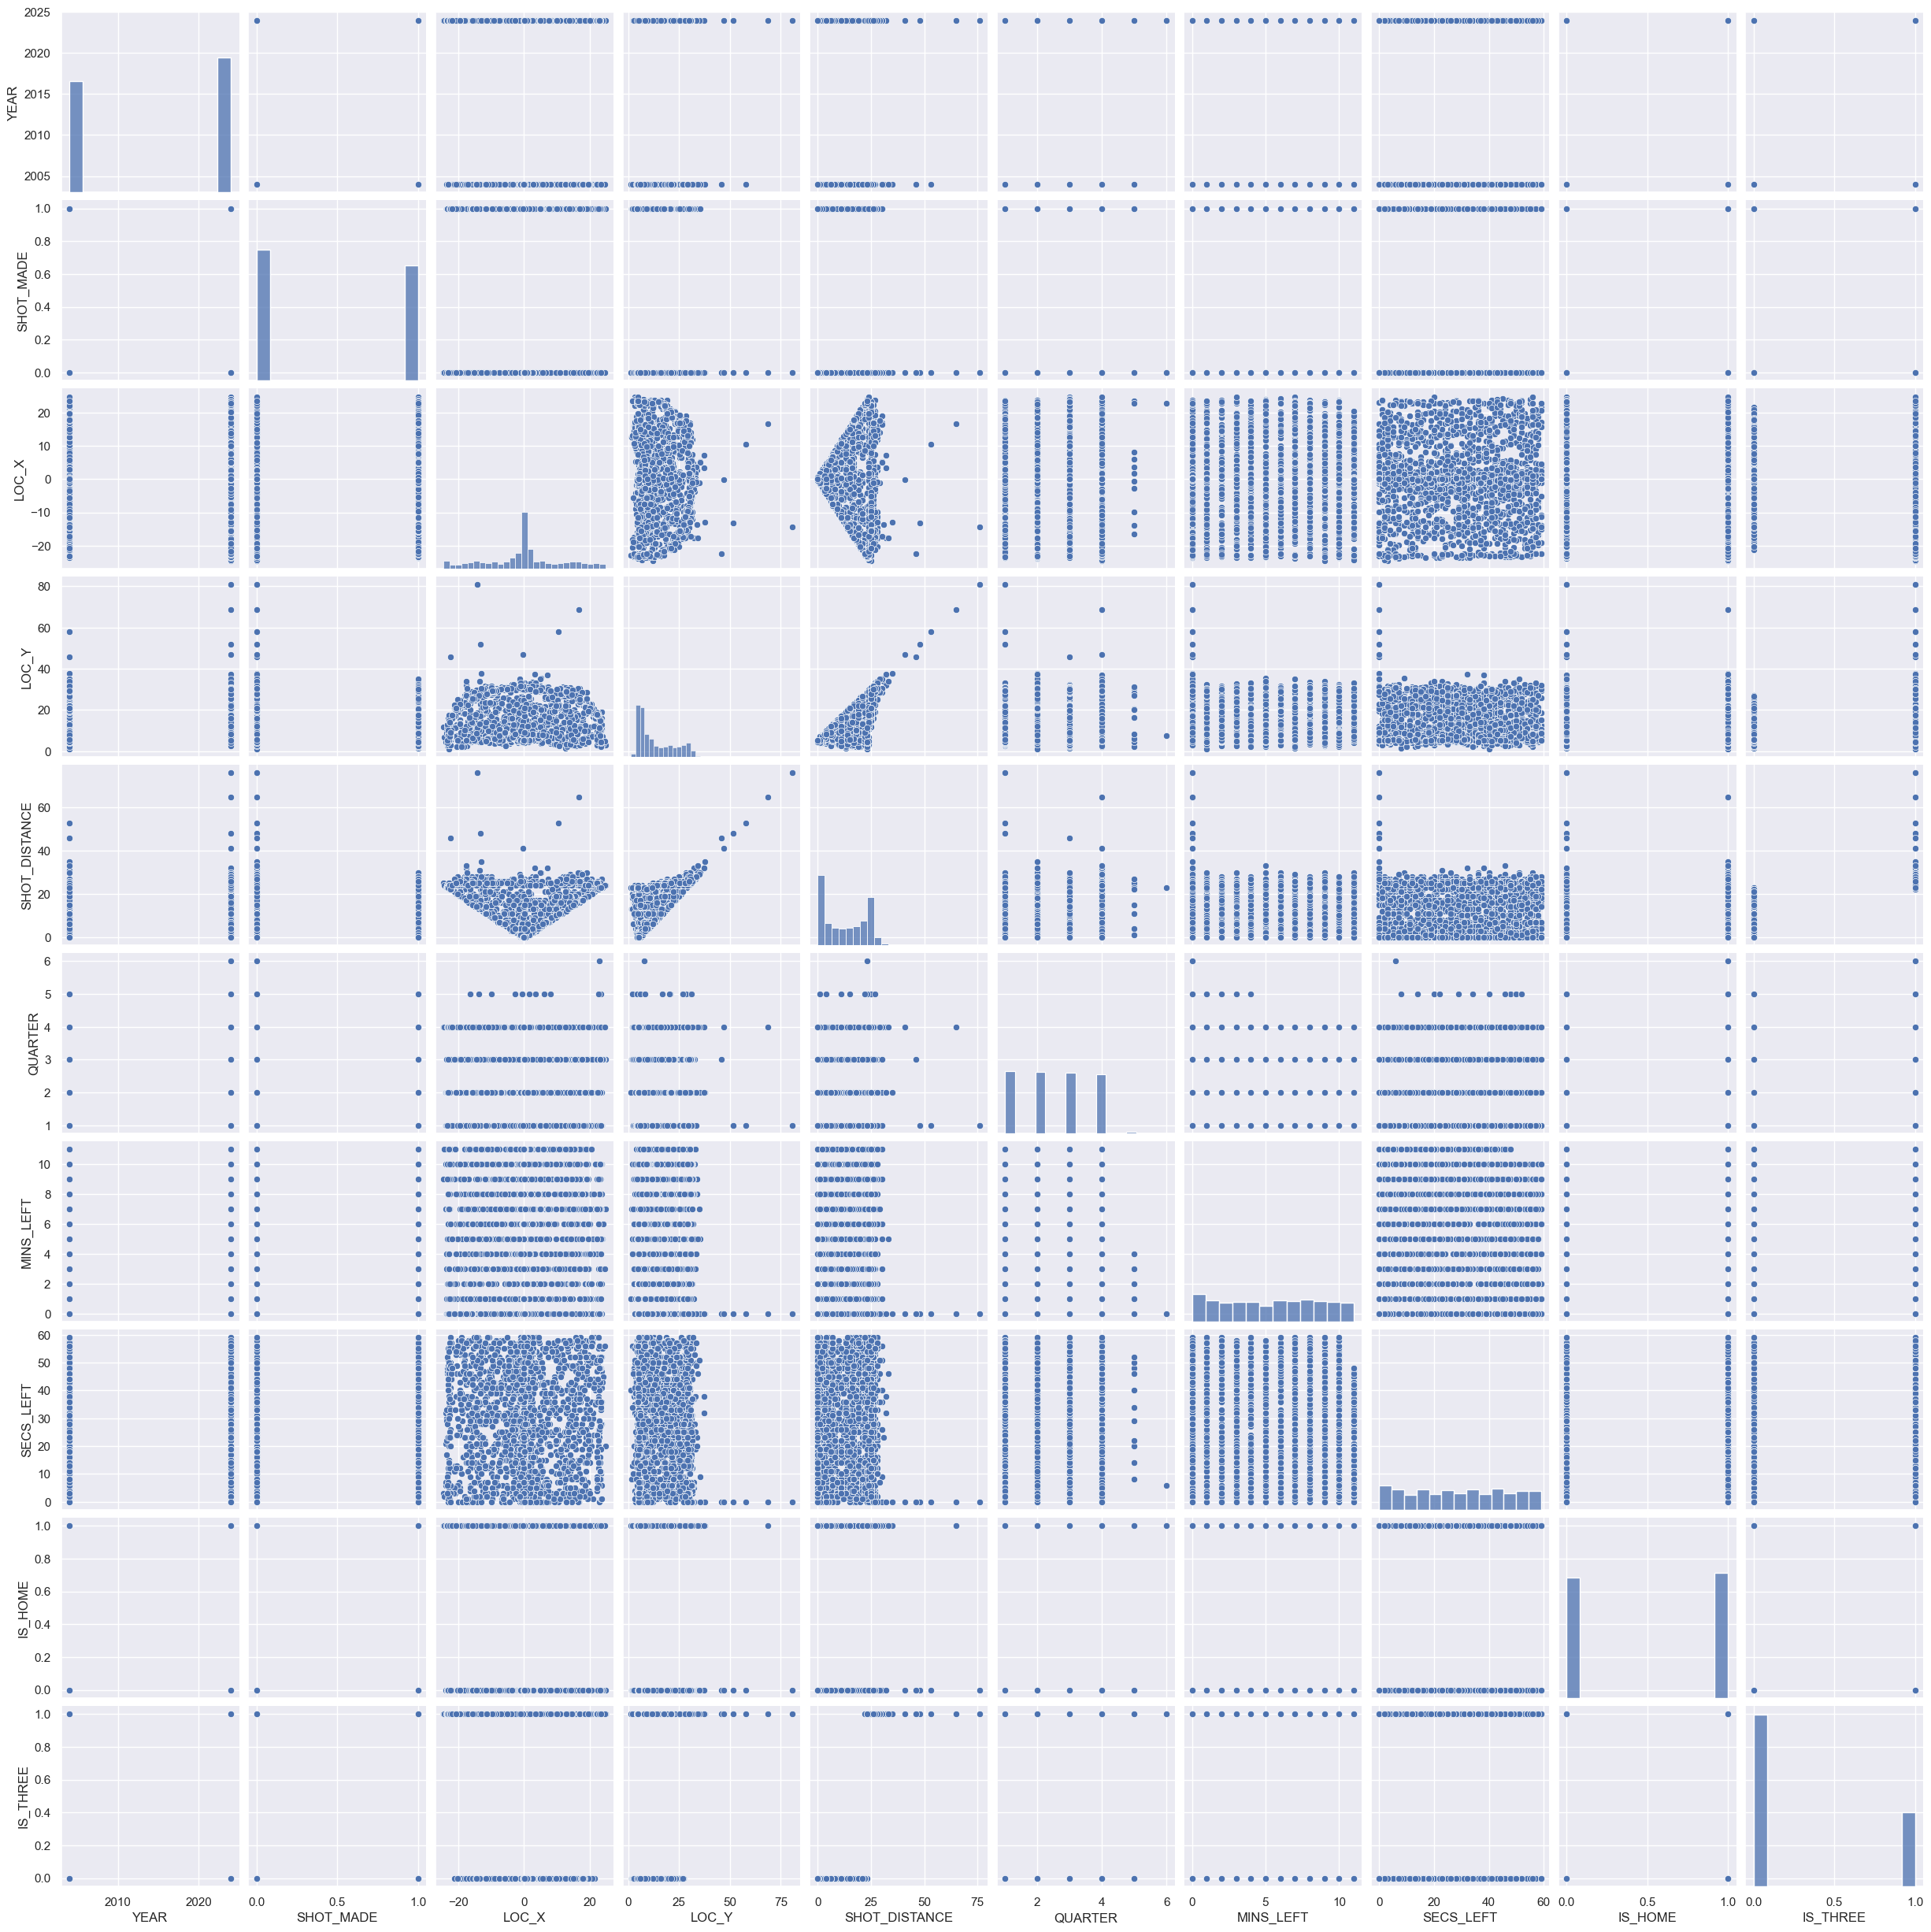

In [134]:
sns.pairplot(df_merged.sample(2000))

The heatmaps show that there is a strong correlation between LOC_Y and SHOT_DISTANCE, which makes sense because LOC_Y is how far away from the baseline the shot was taken. Both of these also have a strong correlation with IS_THREE, which again makes sense because shots from further away will tend to be 3-pointers (it's not a uniform distance because the 3-point line is closer at the corners than at the middle). SHOT_MADE has a negative correlation with IS_THREE, LOC_Y, and SHOT_DISTANCE which is because longer shots will have a lower make rate than shots from up close. Finally, the merged heatmap shows a correlation between YEAR and IS_THREE, which aligns with my expectation that 2024 had more 3-point attempts than 2004.

The pairplots tell a similiar story, as the same relationships can be seen there as well. The pairplot for LOC_X vs LOC_Y shows the outline of the basketball court, which I didn't expect but it makes sense.

The QUARTER, MINS_LEFT, and SECS_LEFT appear to be pretty noisy at the moment. I was hoping that they would be useful in helping to determine if shots towards the end of the game tended to be makes or misses, but based on these graphs it doesn't look like they'll provide too much value to the model.

Overall, the best predictor based on these graphs for SHOT_MADE appears to be SHOT_DISTANCE, which makes sense. However, I think the categorial features we excluded will prove to be integral to the models, as I'd intuitively expect the player  

In [137]:
# Importing LabelEncoder from Sklearn 
# library from preprocessing Module.
from sklearn.preprocessing import LabelEncoder
 
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
label = le.fit_transform(df2004['PLAYER_NAME'])

print(label)

[238  91 238 ... 375 172 127]
